# This notebook implements sleeper agent attack

In this notebook, we will learn how to use ART to run a Hidden Trigger Backdoor Attack Sleeper Agent poisoning attack on a neural network trained with TensorFlow. We will be training our data on a subset of the CIFAR-10 dataset. The methods described are derived from [this paper](https://arxiv.org/pdf/2106.08970.pdf) by Hossein Souri, et. al. 2021.

# Data Normalization and Substitute Model Training 

In [1]:
import os, sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
module_path = os.path.abspath(os.path.join('.'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [ ]:
# import numpy as np
# import os, sys

# module_path = os.path.abspath(os.path.join('..'))
# if module_path not in sys.path:
#     sys.path.append(module_path)
# module_path = os.path.abspath(os.path.join('.'))
# if module_path not in sys.path:
#     sys.path.append(module_path)

# from art.estimators.classification import TensorFlowV2Classifier
# from art.utils import load_cifar10

# (x_train, y_train), (x_test, y_test), min_, max_ = load_cifar10()

# mean = np.mean(x_train,axis=(0,1,2,3))
# std = np.std(x_train,axis=(0,1,2,3))
# x_train = (x_train-mean)/(std+1e-7)
# x_test = (x_test-mean)/(std+1e-7)

# min_ = (min_-mean)/(std+1e-7)
# max_ = (max_-mean)/(std+1e-7)

# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Flatten
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tqdm.keras import TqdmCallback

# tf.get_logger().setLevel('ERROR')

# # Tweaked the model from https://github.com/calmisential/TensorFlow2.0_ResNet
# # MIT License
# def basic_block(x, filter_num, stride=1):
#     conv1 = tf.keras.layers.Conv2D(filters=filter_num,
#                                         kernel_size=(3, 3),
#                                         strides=stride,
#                                         padding="same")
#     bn1 = tf.keras.layers.BatchNormalization()
#     conv2 = tf.keras.layers.Conv2D(filters=filter_num,
#                                         kernel_size=(3, 3),
#                                         strides=1,
#                                         padding="same")
#     bn2 = tf.keras.layers.BatchNormalization()
#     if stride != 1:
#         downsample = tf.keras.Sequential()
#         downsample.add(tf.keras.layers.Conv2D(filters=filter_num,
#                                                     kernel_size=(1, 1),
#                                                     strides=stride))
#         downsample.add(tf.keras.layers.BatchNormalization())
#     else:
#         downsample = tf.keras.layers.Lambda(lambda x: x)

#     residual = downsample(x)
#     x = conv1(x)
#     x = bn1(x)
#     x = tf.nn.relu(x)
#     x = conv2(x)
#     x = bn2(x)
#     output = tf.nn.relu(tf.keras.layers.add([residual, x]))
#     return output

# def basic_block_layer(x, filter_num, blocks, stride=1):
#     x = basic_block(x, filter_num, stride=stride)
#     for _ in range(1, blocks):
#         x = basic_block(x, filter_num, stride=1)
#     return x

# def resnet(x, num_classes, layer_params):
#     pad1 = tf.keras.layers.ZeroPadding2D(padding=1)
#     conv1 = tf.keras.layers.Conv2D(filters=64,
#                                         kernel_size=(3, 3),
#                                         strides=1,
#                                         padding="same")
#     bn1 = tf.keras.layers.BatchNormalization()

#     avgpool = tf.keras.layers.GlobalAveragePooling2D()
#     fc = tf.keras.layers.Dense(units=num_classes, activation=tf.keras.activations.softmax)

#     x = pad1(x)
#     x = conv1(x)
#     x = bn1(x)
#     x = tf.nn.relu(x)
#     x = basic_block_layer(x, filter_num=64,
#                                         blocks=layer_params[0])
#     x = basic_block_layer(x, filter_num=128,
#                                         blocks=layer_params[1],
#                                         stride=2)
#     x = basic_block_layer(x, filter_num=256,
#                                         blocks=layer_params[2],
#                                         stride=2)
#     x = basic_block_layer(x, filter_num=512,
#                                         blocks=layer_params[3],
#                                         stride=2)
#     x = avgpool(x)
#     output = fc(x)
#     return output

# def resnet_18(x, num_classes):
#     return resnet(x, num_classes, layer_params=[2, 2, 2, 2])

# def create_model(x_train, y_train, num_classes=10, batch_size=64, epochs=25, callbacks=[]):
#     inputs = tf.keras.layers.Input(shape=x_train.shape[1:])  # Specify the dimensions
#     outputs = resnet_18(inputs, num_classes)
#     model = tf.keras.models.Model(inputs, outputs)

#     opt = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9, nesterov=True)
#     model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

#     datagen = ImageDataGenerator(
#         featurewise_center=False,
#         samplewise_center=False,
#         featurewise_std_normalization=False,
#         samplewise_std_normalization=False,
#         zca_whitening=False,
#         rotation_range=15,
#         width_shift_range=0.1,
#         height_shift_range=0.1,
#         horizontal_flip=True,
#         vertical_flip=False
#         )
    
#     datagen.fit(x_train)
#     callbacks = callbacks + [TqdmCallback(verbose=0)]
#     model.fit(datagen.flow(x_train, y_train, batch_size=batch_size), steps_per_epoch=x_train.shape[0] // batch_size,epochs=epochs,verbose=0,callbacks=callbacks)
#     return model
    
# model_path = "../../../models/cifar10-resnet18-notebook.h5"
# if not os.path.exists(model_path):
#     model = create_model(x_train, y_train, epochs=80)
#     model.save(model_path)
# else:
#     model = tf.keras.models.load_model(model_path)

# model.evaluate(x_test, y_test)

# model_art = TensorFlowV2Classifier(model, nb_classes=10, input_shape=model.input_shape)

# print("Model and data preparation done.")

In [2]:
import numpy as np
import os, sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
module_path = os.path.abspath(os.path.join('.'))
if module_path not in sys.path:
    sys.path.append(module_path)

from art.estimators.classification import TensorFlowV2Classifier
from art.utils import load_cifar10

(x_train, y_train), (x_test, y_test), min_, max_ = load_cifar10()

mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm.keras import TqdmCallback

tf.get_logger().setLevel('ERROR')

# Tweaked the model from https://github.com/calmisential/TensorFlow2.0_ResNet
# MIT License
def basic_block(x, filter_num, stride=1):
    conv1 = tf.keras.layers.Conv2D(filters=filter_num,
                                        kernel_size=(3, 3),
                                        strides=stride,
                                        padding="same")
    bn1 = tf.keras.layers.BatchNormalization()
    conv2 = tf.keras.layers.Conv2D(filters=filter_num,
                                        kernel_size=(3, 3),
                                        strides=1,
                                        padding="same")
    bn2 = tf.keras.layers.BatchNormalization()
    if stride != 1:
        downsample = tf.keras.Sequential()
        downsample.add(tf.keras.layers.Conv2D(filters=filter_num,
                                                    kernel_size=(1, 1),
                                                    strides=stride))
        downsample.add(tf.keras.layers.BatchNormalization())
    else:
        downsample = tf.keras.layers.Lambda(lambda x: x)

    residual = downsample(x)
    x = conv1(x)
    x = bn1(x)
    x = tf.nn.relu(x)
    x = conv2(x)
    x = bn2(x)
    output = tf.nn.relu(tf.keras.layers.add([residual, x]))
    return output

def basic_block_layer(x, filter_num, blocks, stride=1):
    x = basic_block(x, filter_num, stride=stride)
    for _ in range(1, blocks):
        x = basic_block(x, filter_num, stride=1)
    return x

def resnet(x, num_classes, layer_params):
    pad1 = tf.keras.layers.ZeroPadding2D(padding=1)
    conv1 = tf.keras.layers.Conv2D(filters=64,
                                        kernel_size=(3, 3),
                                        strides=1,
                                        padding="same")
    bn1 = tf.keras.layers.BatchNormalization()

    avgpool = tf.keras.layers.GlobalAveragePooling2D()
    fc = tf.keras.layers.Dense(units=num_classes, activation=tf.keras.activations.softmax)

    x = pad1(x)
    x = conv1(x)
    x = bn1(x)
    x = tf.nn.relu(x)
    x = basic_block_layer(x, filter_num=64,
                                        blocks=layer_params[0])
    x = basic_block_layer(x, filter_num=128,
                                        blocks=layer_params[1],
                                        stride=2)
    x = basic_block_layer(x, filter_num=256,
                                        blocks=layer_params[2],
                                        stride=2)
    x = basic_block_layer(x, filter_num=512,
                                        blocks=layer_params[3],
                                        stride=2)
    x = avgpool(x)
    output = fc(x)
    return output

def resnet_18(x, num_classes):
    return resnet(x, num_classes, layer_params=[2, 2, 2, 2])

# inputs = tf.keras.layers.Input(shape=x_train.shape[1:])  # Specify the dimensions
# outputs = resnet_18(inputs, 10)
# model = tf.keras.models.Model(inputs, outputs)
# optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
# model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])



# Step 3: Create the ART classifier
# x_train_norm = np.copy(x_train)
# # x_test_norm = np.copy(x_test)
# x_train_norm = (x_train_norm - mean)/std
# # x_test_norm = (x_test_norm - mean)/std
# callbacks = [TqdmCallback(verbose=0)]
# model.fit(x_train_norm, y_train, batch_size=64, steps_per_epoch=x_train.shape[0] // 64,epochs=80,verbose=0,callbacks=callbacks)
loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
model = tf.keras.models.load_model('model_art.h5')

def train_step(model, images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    model.optimizer.apply_gradients(zip(gradients, model.trainable_variables))


model_art = TensorFlowV2Classifier(
    model=model,
    loss_object=loss_object,
    train_step=train_step,
    nb_classes=10,
    input_shape=x_train.shape[1:],
    clip_values=(min_,max_),
    preprocessing=(mean,std)
)

# Step 4: Train the ART classifier
# model_art.fit(x_train, y_train, batch_size=64, nb_epochs=1, verbose=0)

# Step 5: Evaluate the ART classifier on benign test examples

predictions = model_art.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

2022-09-16 09:54:21.200629: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-09-16 09:54:22.317331: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-09-16 09:54:22.318439: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-09-16 09:54:22.329051: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:81:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-09-16 09:54:22.329318: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:82:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-

Accuracy on benign test examples: 60.38%


In [ ]:
# model.save('model_art.h5')

# Load Trigger Patch

In [3]:
from PIL import Image
from numpy import asarray
from skimage.transform import resize

patch_size = 8
img = Image.open('trigger_10.png')
numpydata = asarray(img)
patch = resize(numpydata, (patch_size,patch_size,3))
x_train_orig = np.copy(x_train)

# Define Source and Target Class

In [4]:
class_source = 0
class_target = 1
K = 1000

# Select Triggers from Source Class and helper functions for calculating Success Rate

In [5]:
from art.utils import to_categorical

def select_trigger_train(x_train,y_train,K,class_source,class_target):
    x_train_ = np.copy(x_train)
    index_source = np.where(y_train.argmax(axis=1)==class_source)[0][0:K]
    index_target = np.where(y_train.argmax(axis=1)==class_target)[0]
    x_trigger = x_train_[index_source]
    y_trigger  = to_categorical([class_target], nb_classes=10)
    y_trigger = np.tile(y_trigger,(len(index_source),1))
    return x_trigger,y_trigger,index_target

In [6]:
x_trigger,y_trigger,index_target = select_trigger_train(x_train,y_train,K,class_source,class_target)

# Generate Poison Images through attack 

In [12]:
from art.attacks.poisoning.sleeper_agent_attack import SleeperAgentAttack
attack = SleeperAgentAttack(model_art,
                                percent_poison=0.01,
                                max_trials=1,
                                max_epochs=250,
                                learning_rate_schedule=(np.array([1e-1, 1e-2, 1e-3, 1e-4, 1e-5]), [250, 350, 400, 430, 460]),
                                clip_values=(min_,max_),
                                epsilon=16,
                                batch_size=500,
                                verbose=1,
                                indices_target=index_target,
                                patching_strategy="fixed",
                                selection_strategy="random",
                                patch=patch,
                                retraining_factor = 4,
                                model_retrain = False,
                                model_retraining_epoch = 80,
                                class_source = class_source,
                                class_target = class_target
                           )
x_poison, y_poison = attack.poison(x_trigger,y_trigger,x_train,y_train,x_test,y_test) 
indices_poison = attack.get_poison_indices()

  0%|          | 0/1 [00:00<?, ?it/s]

0epoch [00:00, ?epoch/s]

In [ ]:
inputs = tf.keras.layers.Input(shape=x_train.shape[1:])  # Specify the dimensions
outputs = resnet_18(inputs, 10)
model = tf.keras.models.Model(inputs, outputs)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

def train_step(model, images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

# Step 3: Create the ART classifier

model_poisoned = TensorFlowV2Classifier(
    model=model,
    loss_object=loss_object,
    train_step=train_step,
    nb_classes=10,
    input_shape=x_train.shape[1:],
    clip_values=(0, 1),
    preprocessing=(mean,std)
)

# Step 4: Train the ART classifier
model_poisoned.fit(x_poison, y_poison, batch_size=64, nb_epochs=80)

# Step 5: Evaluate the ART classifier on benign test examples

predictions = model_poisoned.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))


In [ ]:
min_

In [ ]:
predictions = model_poisoned.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

# Visualize Trigger, Original and Poisoned Images 

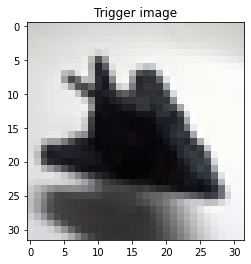

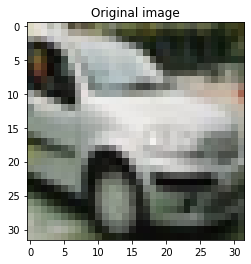

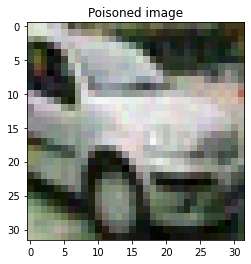

In [11]:
import matplotlib.pyplot as plt
plt.imshow(x_trigger[0])
plt.title('Trigger image')
plt.show()

index_poisoned_example = np.where([np.any(p!=o) for (p,o) in zip(x_poison,x_train)])[0]
plt.imshow(x_train[index_target[indices_poison][0]])
plt.title('Original image')
plt.show()

plt.imshow(x_poison[index_target[indices_poison][0]])
plt.title('Poisoned image')
plt.show()

In [ ]:
np.max(np.abs(x_poison-x_train))*255

# Calculate Success Rate on x_train and x_test

In [ ]:
def add_trigger_patch(x_set,patch_type="fixed"):
    img = Image.open('trigger_10.png')
    numpydata = asarray(img)
    patch = resize(numpydata, (8,8,3))
    if patch_type == "fixed":
        x_set[:,-patch_size:,-patch_size:,:] = patch
    else:
        for x in x_set:
            x_cord = random.randrange(0,x.shape[0] - patch.shape[0] + 1)
            y_cord = random.randrange(0,x.shape[1] - patch.shape[1] + 1)
            x[x_cord:x_cord+patch_size,y_cord:y_cord+patch_size,:]=patch

    return x_set

# Calculate on train images

In [ ]:
import random
index_source_train = np.where(y_train.argmax(axis=1)==class_source)[0]
x_train_trigger = x_train[index_source_train]
print(np.min(x_train_trigger))
x_train_trigger = add_trigger_patch(x_train_trigger,"random")
result_poisoned_train = model_poisoned.predict(x_train_trigger)
print(len(result_poisoned_train))

success_train = (np.argmax(result_poisoned_train,axis=1)==class_target).sum()/result_poisoned_train.shape[0]
print("Train Success Rate",success_train)
plt.imshow(x_train_trigger[0])
plt.title('Trigger image')
plt.show()

In [ ]:
np.min(x_test_trigger)

In [ ]:
import random
index_source_test = np.where(y_test.argmax(axis=1)==class_source)[0]
x_test_trigger = x_test[index_source_test]
x_test_trigger = add_trigger_patch(x_test_trigger,"random")
print(np.max(x_test_trigger))
result_poisoned_test = model_poisoned.predict(x_test_trigger)
print(len(result_poisoned_test))

success_test = (np.argmax(result_poisoned_test,axis=1)==class_source).sum()/result_poisoned_test.shape[0]
print("Test Success Rate:",success_test)

plt.imshow(x_test_trigger[0])
plt.title('Trigger image')
plt.show()

In [ ]:
x_train.shape

In [ ]:
tf.config.list_physical_devices('GPU')

In [ ]:
import tensorflow as tf
visible_devices = tf.config.list_physical_devices('GPU')
tf.config.set_visible_devices(visible_devices[1], 'GPU')

In [ ]:
import tensorflow as tf
tf.config.list_logical_devices('GPU')